In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image

In [12]:
# Path ke direktori dataset di Kaggle
train_dir = "/kaggle/input/dataskinenthusiast/dataskinenth/dataskinent/train"
val_dir = "/kaggle/input/dataskinenthusiast/dataskinenth/dataskinent/val"
test_dir = "/kaggle/input/dataskinenthusiast/dataskinenth/dataskinent/test"

Found 2880 images belonging to 3 classes.
Found 720 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/20
90/90 - 91s - 1s/step - accuracy: 0.5938 - loss: 0.7956 - val_accuracy: 0.6806 - val_loss: 0.5961
Epoch 2/20
90/90 - 88s - 977ms/step - accuracy: 0.6524 - loss: 0.6119 - val_accuracy: 0.7556 - val_loss: 0.5428
Epoch 3/20
90/90 - 88s - 976ms/step - accuracy: 0.6656 - loss: 0.6020 - val_accuracy: 0.7722 - val_loss: 0.5279
Epoch 4/20
90/90 - 88s - 980ms/step - accuracy: 0.6795 - loss: 0.5635 - val_accuracy: 0.7861 - val_loss: 0.4958
Epoch 5/20
90/90 - 88s - 982ms/step - accuracy: 0.6948 - loss: 0.5512 - val_accuracy: 0.6764 - val_loss: 0.6076
Epoch 6/20
90/90 - 87s - 969ms/step - accuracy: 0.6847 - loss: 0.5595 - val_accuracy: 0.7694 - val_loss: 0.4940
Epoch 7/20
90/90 - 88s - 972ms/step - accuracy: 0.7097 - loss: 0.5280 - val_accuracy: 0.7444 - val_loss: 0.5583
Epoch 8/20
90/90 - 141s - 2s/step - accuracy: 0.7049 - loss: 0.5224 - val_accuracy: 0.7778 - va

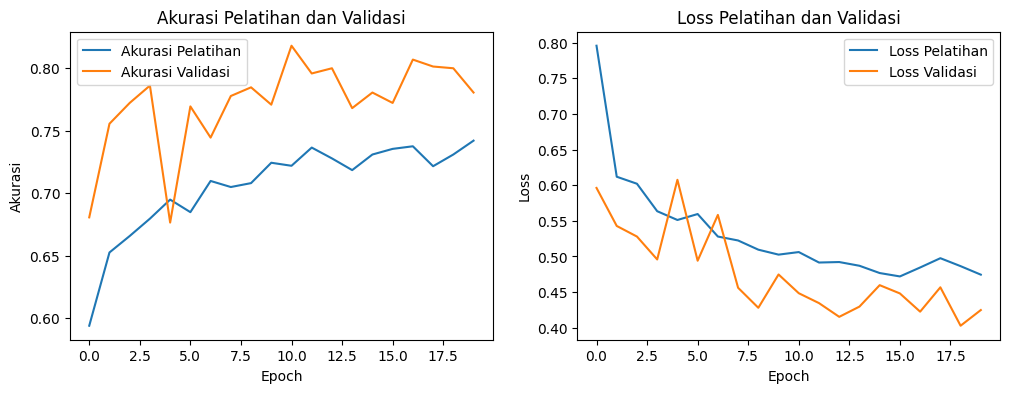

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step


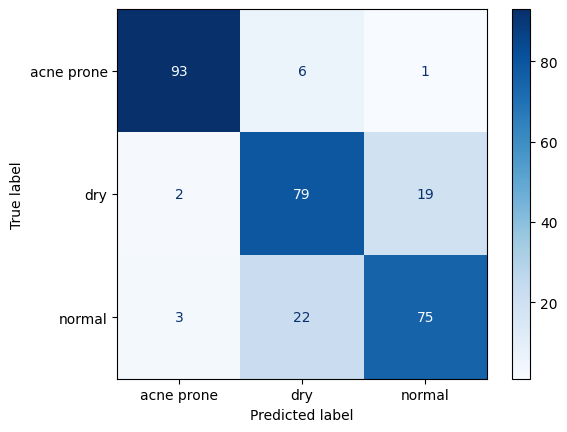

In [14]:
# ImageDataGenerator untuk augmentasi data dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Data generators
batch_size = 32

# Generator data untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Direktori data training
    target_size=(150, 150),  # Ukuran gambar
    batch_size=batch_size,  # Ukuran batch
    class_mode='categorical'  # Mode klasifikasi multi-kelas
)

# Generator data untuk validasi
val_generator = val_datagen.flow_from_directory(
    val_dir,  # Direktori data validasi
    target_size=(150, 150),  # Ukuran gambar
    batch_size=batch_size,  # Ukuran batch
    class_mode='categorical'  # Mode klasifikasi multi-kelas
)

# Generator data untuk pengujian
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Direktori data pengujian
    target_size=(150, 150),  # Ukuran gambar
    batch_size=batch_size,  # Ukuran batch
    class_mode='categorical',  # Mode klasifikasi multi-kelas
    shuffle=False  # Tidak diacak untuk evaluasi
)

# Definisi model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Loss untuk klasifikasi multi-kelas
    metrics=['accuracy']
)

# Melatih model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=2
)

# Evaluasi model pada set pengujian
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f'Akurasi pada data pengujian: {test_accuracy:.2f}')
print(f'Loss pada data pengujian: {test_loss:.2f}')

# Plotting akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi pelatihan
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss pelatihan
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Membuat Confusion Matrix
# Prediksi pada data pengujian
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Gambar ini diprediksi sebagai: dry


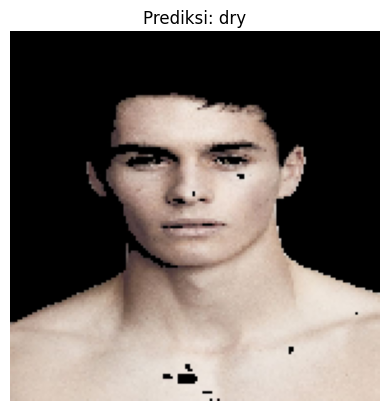

In [16]:
# Simpan model dalam format .h5
model.save('skinenthusiast_model.h5')

# Muat model yang telah disimpan
model = load_model('skinenthusiast_model.h5')

# Proses gambar yang diunggah di Kaggle
img_path = '/kaggle/input/testing/dry/1 (950)_skin.jpg'  # Ganti dengan path gambar yang telah diunggah
# kelas yang benar: dry

# Muat dan proses gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi kelas gambar
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
class_names = list(train_generator.class_indices.keys())

print(f'Gambar ini diprediksi sebagai: {class_names[predicted_class[0]]}')

# Tampilkan gambar dan prediksinya
plt.imshow(img)
plt.title(f'Prediksi: {class_names[predicted_class[0]]}')
plt.axis('off')
plt.show()